In [1]:
using Random
using CSV
using Plots
using DataFrames
using Statistics
using LinearAlgebra

## Data

In [2]:
df = CSV.read("NYC_SPARCS_cancer.csv")
# some preprocessing hence > 33 columns

,Health Service Area,Hospital County,Operating Certificate Number,Facility ID
,String,String,Int64,Int64
1,New York City,Bronx,7000002,1165
2,New York City,Bronx,7000002,1165
3,New York City,Bronx,7000002,1165
4,New York City,Bronx,7000002,1165
5,New York City,Bronx,7000002,1165
6,New York City,Bronx,7000002,1165
7,New York City,Bronx,7000002,1165
8,New York City,Bronx,7000002,1165
9,New York City,Bronx,7000002,1165


In [3]:
rename!(df, [i => replace(string(i), " "=>"_") |> Symbol for i in names(df)])
rename!(df, "Zip_Code_-_3_digits" => :Zip_Code)
print("rename")

rename

In [4]:
# println(names(df))

- Using Hospital_County for location instead of "Zip_Code", "Health_Service_Area", "Operating_Certificate_Number", "Facility_ID", and "Facility_Name".  
- Removing Discharge_Year since it is 2012 for every row.
- Using CSS_Diagnosis_Code for diagnosis instead of "CCS_Diagnosis_Description", "CCS_Procedure_Code", "CCS_Procedure_Description", "APR_DRG_Code", "APR_DRG_Description", "APR_MDC_Code", and "APR_MDC_Description". There is repetition among these columns (collinearity) or have too many options > 200 (too specific).
- Removing APR_Severity_of_Illness_Description since it is a repeat.
- Removing "Payment_Typology_2" and "Payment_Typology_3" since there is already Payment_Typology_1.
- Removing "Birth_Weight" and "Abortion_Edit_Indicator" since it applies to few patients.
- Removing Total_Charges because length of stay, the target variable, likely factors into the charge.
- Note: using numeric ordinal for age and risk of mortality
- Type_of_Admission includes emergency

In [4]:
good_features = [
    :Age_Ordinal,                      # ordinal
    :Hospital_County,                  # nominal
    :Gender_F,                         # 0/1
    :Race,                             # nominal
    :Ethnicity,                        # nominal
    :Type_of_Admission,                # nominal
    :Patient_Disposition,              # nominal
    :CCS_Diagnosis_Code,               # nominal
    :APR_Severity_of_Illness_Code,     # ordinal
    :APR_Risk_of_Mortality_Ordinal,    # ordinal
    :APR_Medical_Surgical_Description, # nominal
    :Payment_Typology_1,               # nominal
]

12-element Array{Symbol,1}:
 :Age_Ordinal
 :Hospital_County
 :Gender_F
 :Race
 :Ethnicity
 :Type_of_Admission
 :Patient_Disposition
 :CCS_Diagnosis_Code
 :APR_Severity_of_Illness_Code
 :APR_Risk_of_Mortality_Ordinal
 :APR_Medical_Surgical_Description
 :Payment_Typology_1

In [5]:
Random.seed!(1)
df = df[shuffle(1:end), :] # we shuffle the data so that our train/test split will be truly random

train_proportion = 0.7
n = size(df, 1)
println("Size of dataset: ", string(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
ntrain = convert(Int, round(train_proportion*n))

df.Length_of_Stay = replace.(df.Length_of_Stay, Ref("120 +" => "120"))
df[:Length_of_Stay] = parse.(Float64, df[:Length_of_Stay])
target = df[:, :Length_of_Stay]
            
data = df[:, good_features]

#Now we will split the data to create training and test sets. 

# the following variable records the features of examples in the training set
xtrain = data[1:ntrain, :]
# the following variable records the features of examples in the test set
xtest = data[ntrain+1:n, :]
# the following variable records the labels of examples in the training set
ytrain = target[1:ntrain, :]
# the following variable records the labels of examples in the test set
ytest = target[ntrain+1:n, :]
print("done")

Size of dataset: 35804
done

## Helper Functions

In [6]:
"""This function just computes the mean squared error."""
function MSE(y, pred)
    return mean((y-pred).^2)
end

MSE

In [7]:
"""This function just computes the mean absolute error."""
function MAE(y, pred)
    return mean(abs.(y-pred))
end

MAE

In [8]:
"""This completed function plots the main diagonal; 
for a "predicted vs true" plot with perfect predictions,
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

"""This completed helper funciton plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname; margin=.05, plotDiag=true, zeromin=false)
    scatter(x,y, label="data")
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
    if zeromin
        ylims!((0.0,maximum(y)+margin*range_y))
        xlims!((0.0,maximum(x)+margin*range_x))
    else
        ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
        xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
    end
end

"""This completed function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted", "True", zeromin=true)
end

plot_pred_true

In [9]:
"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    result = zeros(length(column), length(cats))
    for e in 1:length(column)    # each entry in column
        for c in 1:length(cats)
            if column[e] === cats[c]
                result[e,c] = 1
            end           
        end
    end
    result
end

onehot

## Feature Correlation

Find features with highest correlation

In [10]:
one_hot_features = [
    :Hospital_County,                  # nominal
    :Race,                             # nominal
    :Ethnicity,                        # nominal
    :Type_of_Admission,                # nominal
    :Patient_Disposition,              # nominal
    :CCS_Diagnosis_Code,               # nominal
    :APR_Medical_Surgical_Description, # nominal
    :Payment_Typology_1,               # nominal
]

8-element Array{Symbol,1}:
 :Hospital_County
 :Race
 :Ethnicity
 :Type_of_Admission
 :Patient_Disposition
 :CCS_Diagnosis_Code
 :APR_Medical_Surgical_Description
 :Payment_Typology_1

In [11]:
train_cor = []

#Sets of all categories in a particular column
cats_sets = [unique(xtrain[:, label]) for label in one_hot_features]
train_f = 0
for i in 1:8
    one_feature_cor = []
    f = one_hot_features[i]
    train_f = onehot(xtrain[:, f], cats_sets[i])
    test_f = onehot(xtest[:, f], cats_sets[i])
    
    append!(one_feature_cor, cor(ytrain, train_f))
    append!(train_cor, mean(abs.(one_feature_cor)))
end

In [12]:
train_cor

8-element Array{Any,1}:
 0.0915456545224654
 0.03598448203278114
 0.029062165290436214
 0.049837264003141
 0.07131339466405713
 0.042542675207389316
 0.19143641402621503
 0.03958852084806956

## Feature Cross-Validation

In [13]:
"""5-fold cross-validation (poorly coded, apologies)"""
function crossval(features, k, trainx, trainy, ordinals)
    nrow = size(trainx, 1)
    eachsize = floor(Int, nrow/k)
    Random.seed!(k)
    dftrainy = convert(DataFrame, trainy)
    comb = hcat(trainx, dftrainy)
    comb = comb[shuffle(1:end), :]
    comb_f = propertynames(comb)
    target = comb[:, :x1]
    rest = comb[:, filter(col -> (col != :x1), comb_f)]
    xs1 = rest[1:eachsize, :]
    ys1 = target[1:eachsize, :]
    xs2 = rest[(eachsize + 1):2*eachsize, :]
    ys2 = target[(eachsize + 1):2*eachsize, :]
    xs3 = rest[(2*eachsize + 1):3*eachsize, :]
    ys3 = target[(2*eachsize + 1):3*eachsize, :]
    xs4 = rest[(3*eachsize + 1):4*eachsize, :]
    ys4 = target[(3*eachsize + 1):4*eachsize, :]
    xs5 = rest[(4*eachsize + 1):5*eachsize, :]
    ys5 = target[(4*eachsize + 1):5*eachsize, :]
    
    cv1 = vcat(xs2,xs3,xs4,xs5)
    cv2 = vcat(xs1,xs3,xs4,xs5)
    cv3 = vcat(xs1,xs2,xs4,xs5)
    cv4 = vcat(xs1,xs2,xs3,xs5)
    cv5 = vcat(xs2,xs3,xs4,xs1)
    y1 = vcat(ys2,ys3,ys4,ys5)    
    y2 = vcat(ys1,ys3,ys4,ys5)
    y3 = vcat(ys1,ys2,ys4,ys5)
    y4 = vcat(ys1,ys2,ys3,ys5)
    y5 = vcat(ys2,ys3,ys4,ys1)
    for j in features
        trainmae = []
        testmae = []
        cats_sets2 = [unique(rest[:, label]) for label in j]
        
        train_all2 = hcat([onehot(cv1[:, j[i]], cats_sets2[i]) for i in 1:size(j, 1)]...)
        test_all2 = hcat([onehot(xs1[:, j[i]], cats_sets2[i]) for i in 1:size(j, 1)]...)
        ord1 = convert(Matrix, cv1[:,ordinals])
        ord2 = convert(Matrix, xs1[:,ordinals])
        train2 = hcat(train_all2, ord1 , ones(4*eachsize))
        test2 = hcat(test_all2, ord2, ones(eachsize))
        w1 = train2\y1
        predtrain = train2*w1
        predtest = test2*w1
        append!(trainmae, MAE(y1, predtrain))
        append!(testmae, MAE(ys1, predtest))
        
        train_all2 = hcat([onehot(cv2[:, j[i]], cats_sets2[i]) for i in 1:size(j, 1)]...)
        test_all2 = hcat([onehot(xs2[:, j[i]], cats_sets2[i]) for i in 1:size(j, 1)]...) 
        ord3 = convert(Matrix, cv2[:,ordinals])
        ord4 = convert(Matrix, xs2[:,ordinals])
        train2 = hcat(train_all2, ord3, ones(4*eachsize))
        test2 = hcat(test_all2, ord4, ones(eachsize))
        w2 = train2\y2
        predtrain = train2*w2
        predtest = test2*w2
        append!(trainmae, MAE(y2, predtrain))
        append!(testmae, MAE(ys2, predtest))
        
        train_all2 = hcat([onehot(cv3[:, j[i]], cats_sets2[i]) for i in 1:size(j, 1)]...)
        test_all2 = hcat([onehot(xs3[:, j[i]], cats_sets2[i]) for i in 1:size(j, 1)]...) 
        ord5 = convert(Matrix, cv3[:,ordinals])
        ord6 = convert(Matrix, xs3[:,ordinals])
        train2 = hcat(train_all2, ord5, ones(4*eachsize))
        test2 = hcat(test_all2, ord6, ones(eachsize))
        w3 = train2\y3
        predtrain = train2*w3
        predtest = test2*w3
        append!(trainmae, MAE(y3, predtrain))
        append!(testmae, MAE(ys3, predtest))
        
        train_all2 = hcat([onehot(cv4[:, j[i]], cats_sets2[i]) for i in 1:size(j, 1)]...)
        test_all2 = hcat([onehot(xs4[:, j[i]], cats_sets2[i]) for i in 1:size(j, 1)]...) 
        ord7 = convert(Matrix, cv4[:,ordinals])
        ord8 = convert(Matrix, xs4[:,ordinals])
        train2 = hcat(train_all2, ord7, ones(4*eachsize))
        test2 = hcat(test_all2, ord8, ones(eachsize))
        w4 = train2\y4
        predtrain = train2*w4
        predtest = test2*w4
        append!(trainmae, MAE(y4, predtrain))
        append!(testmae, MAE(ys4, predtest))
        
        train_all2 = hcat([onehot(cv5[:, j[i]], cats_sets2[i]) for i in 1:size(j, 1)]...)
        test_all2 = hcat([onehot(xs5[:, j[i]], cats_sets2[i]) for i in 1:size(j, 1)]...) 
        ord9 = convert(Matrix, cv5[:,ordinals])
        ord10 = convert(Matrix, xs5[:,ordinals])
        train2 = hcat(train_all2, ord9, ones(4*eachsize))
        test2 = hcat(test_all2, ord10, ones(eachsize))
        w5 = train2\y5
        predtrain = train2*w5
        predtest = test2*w5
        append!(trainmae, MAE(y5, predtrain))
        append!(testmae, MAE(ys5, predtest))
        
        println("Model")
        println("Train MAE\t", string(mean(trainmae)))
        println("Test MAE \t", string(mean(testmae)))
    end
end

crossval

In [14]:
ordcv = [
    :APR_Severity_of_Illness_Code
    :APR_Risk_of_Mortality_Ordinal
]
featcv = [[:Type_of_Admission],
    [:Type_of_Admission,:Patient_Disposition],
    [:Type_of_Admission,:CCS_Diagnosis_Code],
    [:CCS_Diagnosis_Code]
]

4-element Array{Array{Symbol,1},1}:
 [:Type_of_Admission]
 [:Type_of_Admission, :Patient_Disposition]
 [:Type_of_Admission, :CCS_Diagnosis_Code]
 [:CCS_Diagnosis_Code]

In [15]:
crossval(featcv, 5, xtrain, ytrain, ordcv)

Model
Train MAE	5.045122578095279
Test MAE 	5.047001520667992
Model
Train MAE	4.753667730258106
Test MAE 	4.762121913090053
Model
Train MAE	5.004088683442196
Test MAE 	5.008538791277424
Model
Train MAE	4.981533423634927
Test MAE 	4.985081474169808


## Bootstrap Variance

In [16]:
"""Linear prediction"""
function lin(x, w)
    y = 0
    for k=1:length(w)-1
        y += w[k]*x
    end
    y += w[length(w)]
    return y
end

lin

In [17]:
"""Using bootstrap to estimate variance"""
function bootdata(n,x,y,other)
    K = 500
    ncol = size(x,2)
    w_b = reshape([],0,ncol)
    for p=1:K
        mysample = rand(1:n,n)
        xk,yk = x[mysample,:], y[mysample,:]
        w_Dc = xk\yk
        w_b = vcat(w_b, w_Dc')
    end
    w_mc = []
    for j in 1:ncol
        append!(w_mc, mean(w_b[j]))
    end
    c_avg2(x) = lin(x,w_mc)
    
    cbsum = 0
    for p=1:K
        mysample = rand(1:n,n)
        xk,yk = x[mysample], y[mysample]
        w_Dc = xk\yk
        c_D(x) = lin(x,w_Dc)
        sqvarc2(x) = (c_D(x) - c_avg2(x))^2
        cbsum += mean(sqvarc2(x) for x in other)
    end
    bootvar = cbsum/K
    
    return bootvar
end

bootdata

In [ ]:
bootdata(nn,xx1,ys1,xxx1)
bootdata(nn,xx2,ys1,xxx2)
bootdata(nn,xx3,ys1,xxx3)
bootdata(nn,xx4,ys1,xxx4)
bootdata(nn,xx5,ys1,xxx5)

In [19]:
nn = 5000
Random.seed!(100)
dftrainy = convert(DataFrame, ytrain)
comb = hcat(xtrain, dftrainy)
comb = comb[shuffle(1:end), :]
comb_f = propertynames(comb)
tart = comb[:, :x1]
rest = comb[:, filter(col -> (col != :x1), comb_f)]
xs1 = rest[1:nn, :]
ys1 = tart[1:nn, :]

featcv1 = [:Type_of_Admission]
featcv2 = [:Type_of_Admission,:Patient_Disposition]
featcv3 = [:Type_of_Admission,:CCS_Diagnosis_Code]
featcv4 = [:CCS_Diagnosis_Code]

cats_sets2 = [unique(rest[:, label]) for label in featcv1]
train_all2 = hcat([onehot(xs1[:, featcv1[i]], cats_sets2[i]) for i in 1:1]...)
ord1 = convert(Matrix, xs1[:,ordinals])
xx1 = hcat(train_all2, ord1 , ones(nn))

cats_sets2 = [unique(rest[:, label]) for label in featcv2]
train_all2 = hcat([onehot(xs1[:, featcv2[i]], cats_sets2[i]) for i in 1:2]...)
ord1 = convert(Matrix, xs1[:,ordinals])
xx2 = hcat(train_all2, ord1 , ones(nn))

cats_sets2 = [unique(rest[:, label]) for label in featcv3]
train_all2 = hcat([onehot(xs1[:, featcv3[i]], cats_sets2[i]) for i in 1:2]...)
ord1 = convert(Matrix, xs1[:,ordinals])
xx3 = hcat(train_all2, ord1 , ones(nn))

cats_sets2 = [unique(rest[:, label]) for label in featcv4]
train_all2 = hcat([onehot(xs1[:, featcv4[i]], cats_sets2[i]) for i in 1:1]...)
ord1 = convert(Matrix, xs1[:,ordinals])
xx4 = hcat(train_all2, ord1 , ones(nn))

print("bootstrap data")

bootstrap data

In [20]:
Random.seed!(101)
dftrainy = convert(DataFrame, ytrain)
comb = hcat(xtrain, dftrainy)
comb = comb[shuffle(1:end), :]
comb_f = propertynames(comb)
tart = comb[:, :x1]
rest = comb[:, filter(col -> (col != :x1), comb_f)]
xs1 = rest[1:nn, :]
ys11 = tart[1:nn, :]

featcv1 = [:Type_of_Admission]
featcv2 = [:Type_of_Admission,:Patient_Disposition]
featcv3 = [:Type_of_Admission,:CCS_Diagnosis_Code]
featcv4 = [:CCS_Diagnosis_Code]

cats_sets2 = [unique(rest[:, label]) for label in featcv1]
train_all2 = hcat([onehot(xs1[:, featcv1[i]], cats_sets2[i]) for i in 1:1]...)
ord1 = convert(Matrix, xs1[:,ordinals])
xxx1 = hcat(train_all2, ord1 , ones(nn))


cats_sets2 = [unique(rest[:, label]) for label in featcv2]
train_all2 = hcat([onehot(xs1[:, featcv2[i]], cats_sets2[i]) for i in 1:2]...)
ord1 = convert(Matrix, xs1[:,ordinals])
xxx2 = hcat(train_all2, ord1 , ones(nn))

cats_sets2 = [unique(rest[:, label]) for label in featcv3]
train_all2 = hcat([onehot(xs1[:, featcv3[i]], cats_sets2[i]) for i in 1:2]...)
ord1 = convert(Matrix, xs1[:,ordinals])
xxx3 = hcat(train_all2, ord1 , ones(nn))

cats_sets2 = [unique(rest[:, label]) for label in featcv4]
train_all2 = hcat([onehot(xs1[:, featcv4[i]], cats_sets2[i]) for i in 1:1]...)
ord1 = convert(Matrix, xs1[:,ordinals])
xxx4 = hcat(train_all2, ord1 , ones(nn))

print("expectation data")

expectation data

## Error

In [27]:
one_hot_features = [
    :Hospital_County,                  # nominal
    :Race,                             # nominal
    :Ethnicity,                        # nominal
    :Type_of_Admission,                # nominal
    :Patient_Disposition,              # nominal
    :CCS_Diagnosis_Code,               # nominal
    :APR_Medical_Surgical_Description, # nominal
    :Payment_Typology_1,               # nominal
]
one_hot_features2 = [
#     :Hospital_County,                  # nominal
#     :Race,                             # nominal
#     :Ethnicity,                        # nominal
    :Type_of_Admission,                # nominal
#     :Patient_Disposition,              # nominal
    :CCS_Diagnosis_Code,               # nominal
#     :APR_Medical_Surgical_Description, # nominal
#     :Payment_Typology_1,               # nominal
]
cats_sets2 = [unique(xtrain[:, label]) for label in one_hot_features2]
ordinals = [
    :APR_Severity_of_Illness_Code
#     :Age_Ordinal
#     :Gender_F
    :APR_Risk_of_Mortality_Ordinal
]

2-element Array{Symbol,1}:
 :APR_Severity_of_Illness_Code
 :APR_Risk_of_Mortality_Ordinal

In [28]:
train_all2 = hcat([onehot(xtrain[:, one_hot_features2[i]], cats_sets2[i]) for i in 1:size(one_hot_features2, 1)]...)
test_all2 = hcat([onehot(xtest[:, one_hot_features2[i]], cats_sets2[i]) for i in 1:size(one_hot_features2, 1)]...) 
ordtrain2 = convert(Matrix, xtrain[:, ordinals])
ordtest2 = convert(Matrix, xtest[:, ordinals])
train_off2 = hcat(train_all2, ordtrain2, ones(ntrain))
test_off2 = hcat(test_all2, ordtest2, ones(n-ntrain))

w = train_off2\ytrain

predtrain = train_off2*w
predtest = test_off2*w

trainMAE = MAE(ytrain, predtrain)
testMAE = MAE(ytest, predtest)

println("Train MAE\t", string(trainMAE))
println("Test MAE \t", string(testMAE))

Train MAE	5.002604513011621
Test MAE 	4.962646615650045


In [22]:
# all
cats_sets = [unique(xtrain[:, label]) for label in one_hot_features]
train_all = hcat([onehot(xtrain[:, one_hot_features[i]], cats_sets[i]) for i in 1:size(one_hot_features, 1)]...)
test_all = hcat([onehot(xtest[:, one_hot_features[i]], cats_sets[i]) for i in 1:size(one_hot_features, 1)]...) 
ordtrain = convert(Matrix, xtrain[:, [:APR_Severity_of_Illness_Code,:Age_Ordinal,:Gender_F,:APR_Risk_of_Mortality_Ordinal]])
ordtest = convert(Matrix, xtest[:, [:APR_Severity_of_Illness_Code,:Age_Ordinal,:Gender_F,:APR_Risk_of_Mortality_Ordinal]])
train_off = hcat(train_all, ordtrain, ones(ntrain))
test_off = hcat(test_all, ordtest, ones(n-ntrain))

w = train_off\ytrain

predtrain = train_off*w
predtest = test_off*w

trainMAE = MAE(ytrain, predtrain)
testMAE = MAE(ytest, predtest)

println("Train MAE\t", string(trainMAE))
println("Test MAE \t", string(testMAE))

Train MAE	4.698908030993512
Test MAE 	4.749343312502804


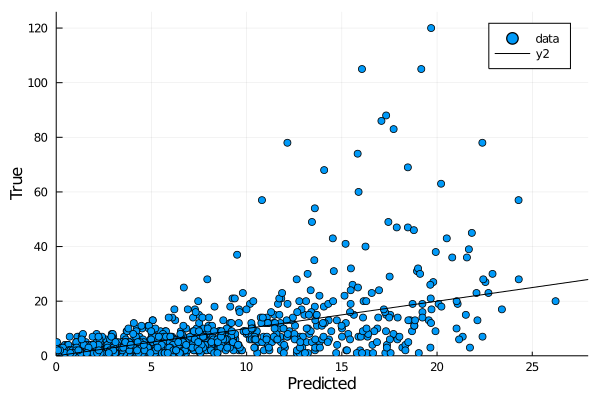

In [23]:
plot_pred_true(predtest, ytest)

## Other

#### Feature Weights

In [24]:
for i in w
    if abs(i) < 0.1
        println(i)
    end
end

-0.07665246154984962
0.019822010282479874
0.09846309761953953


#### Feature Errors

In [25]:
train_MAE_all = []
test_MAE_all = []

for i in 1:8
    f = one_hot_features[i]
    train_f = hcat(onehot(xtrain[:, f], cats_sets[i]), ones(ntrain))
    train_f = convert(Matrix, train_f)
    test_f = hcat(onehot(xtest[:, f], cats_sets[i]), ones(n-ntrain))
    test_f = convert(Matrix, test_f)
    
    wf = train_f\ytrain
    train_pred = train_f*wf
    test_pred = test_f*wf

    train_MAE = MAE(ytrain, train_pred)
    test_MAE = MAE(ytest, test_pred)

    println(f)
    println("Train MAE\t", train_MAE)
    println("Test MAE \t", test_MAE)
    
    append!(train_MAE_all, train_MAE)
    append!(test_MAE_all, test_MAE)
end

Hospital_County
Train MAE	5.983468526969202
Test MAE 	6.021411261812942
Race
Train MAE	6.111283705686669
Test MAE 	6.108959635901568
Ethnicity
Train MAE	6.1461685887501
Test MAE 	6.153798160778501
Type_of_Admission
Train MAE	5.910794875540587
Test MAE 	5.905080053996327
Patient_Disposition
Train MAE	5.229767109261987
Test MAE 	5.309713168675841
CCS_Diagnosis_Code
Train MAE	5.506724096659546
Test MAE 	5.569270699708384
APR_Medical_Surgical_Description
Train MAE	5.988940356872946
Test MAE 	6.0048597730212725
Payment_Typology_1
Train MAE	6.027259128980813
Test MAE 	6.057894106006193


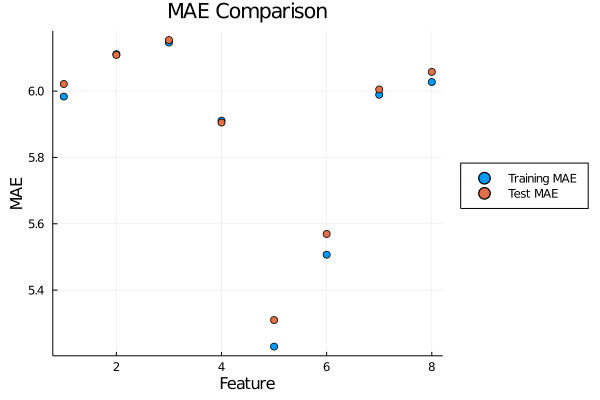

In [26]:
error_df = DataFrame(Features=1:8, TrainMAE=train_MAE_all, TestMAE=test_MAE_all)

scatter(error_df[:, :Features], error_df[:, :TrainMAE], label="Training MAE", title="MAE Comparison")
scatter!(error_df[:, :Features], error_df[:, :TestMAE], label="Test MAE", legend=:outerright)
xlabel!("Feature")
ylabel!("MAE")